<a href="https://colab.research.google.com/github/vicensi/Deep-learning/blob/main/PETR4_transformer_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
np.set_printoptions(threshold=np.inf)

In [ ]:
#Carrega o dataset
#international airline passengers problem with time step regression framing

dataframe_teste = read_csv('/content/drive/MyDrive/Pasta sem nome/deep learnig/PETR4.SA-20240512T195755Z-001/PETR4.SA/teste.csv', usecols =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], engine='python')
dataframe_treino = read_csv('/content/drive/MyDrive/Pasta sem nome/deep learnig/PETR4.SA-20240512T195755Z-001/PETR4.SA/treino.csv', usecols =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], engine='python')
dataframe_treino.head(150)

,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,2000-01-24,1.274788,1.347845,-1,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995,1.351823,1.356514,1.370341,1.450586
1,2000-01-25,1.274788,1.340540,-1,1.274788,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995,1.351823,1.356514,1.370341
2,2000-01-26,1.290096,1.335495,-1,1.274788,1.274788,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995,1.351823,1.356514
3,2000-01-27,1.280960,1.330042,-1,1.290096,1.274788,1.274788,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995,1.351823
4,2000-01-28,1.280960,1.325134,-1,1.280960,1.290096,1.274788,1.274788,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2000-08-14,1.537004,1.493703,1,1.540090,1.527745,1.390402,1.418179,1.467869,1.435154,1.439475,1.435463,1.404291,1.445031,1.425895,1.481141,1.504597,1.490708,1.574040
146,2000-08-15,1.555522,1.499885,1,1.537004,1.540090,1.527745,1.390402,1.418179,1.467869,1.435154,1.439475,1.435463,1.404291,1.445031,1.425895,1.481141,1.504597,1.490708
147,2000-08-16,1.574040,1.507301,1,1.555522,1.537004,1.540090,1.527745,1.390402,1.418179,1.467869,1.435154,1.439475,1.435463,1.404291,1.445031,1.425895,1.481141,1.504597
148,2000-08-17,1.635768,1.520147,1,1.574040,1.555522,1.537004,1.540090,1.527745,1.390402,1.418179,1.467869,1.435154,1.439475,1.435463,1.404291,1.445031,1.425895,1.481141


In [ ]:
dataframe_treino['Label'] = dataframe_treino['Label'].replace(-1, 0)
dataframe_teste['Label'] = dataframe_teste['Label'].replace(-1, 0)

In [ ]:
#Normaliza o dataset
scaler = MinMaxScaler()
dataframe_treino['Smoothed_Close'] = scaler.fit_transform(dataframe_treino['Smoothed_Close'].values.reshape(-1, 1))
dataframe_teste['Smoothed_Close'] = scaler.fit_transform(dataframe_teste['Smoothed_Close'].values.reshape(-1, 1))

In [ ]:
dataframe_teste

,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,2019-02-26,9.467936,0.120662,1,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673,9.289832
1,2019-02-27,9.646040,0.121555,1,9.467936,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673
2,2019-02-28,9.638913,0.122335,1,9.646040,9.467936,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191
3,2019-03-01,9.510681,0.122613,1,9.638913,9.646040,9.467936,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439
4,2019-03-06,9.532050,0.122933,1,9.510681,9.638913,9.646040,9.467936,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198,2023-12-21,36.389999,0.977830,1,36.380001,36.250000,35.840000,35.400002,35.320000,34.570000,34.080002,34.360001,34.490002,33.419998,33.500000,34.750000,34.910000,35.669998,35.910000
1199,2023-12-22,36.740002,0.982796,1,36.389999,36.380001,36.250000,35.840000,35.400002,35.320000,34.570000,34.080002,34.360001,34.490002,33.419998,33.500000,34.750000,34.910000,35.669998
1200,2023-12-26,37.330002,0.989222,1,36.740002,36.389999,36.380001,36.250000,35.840000,35.400002,35.320000,34.570000,34.080002,34.360001,34.490002,33.419998,33.500000,34.750000,34.910000
1201,2023-12-27,37.360001,0.995104,1,37.330002,36.740002,36.389999,36.380001,36.250000,35.840000,35.400002,35.320000,34.570000,34.080002,34.360001,34.490002,33.419998,33.500000,34.750000


In [ ]:
#funcao para criar as janelas
import numpy as np

def create_time_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data['Smoothed_Close'].values[i:i+window_size])
        y.append(data['Label'].values[i+window_size])
    return np.array(X), np.array(y)



In [ ]:

window_size = 15

In [ ]:
# criando as janelas de treino
window_size = 15
X_train, y_train = create_time_windows(dataframe_treino, window_size)

# Reshape X para (n_samples, window_size, 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

In [ ]:
X_train.shape

(4793, 15, 1)

In [ ]:
# criando as janelas de teste
window_size = 15
X_test, y_test = create_time_windows(dataframe_teste, window_size)

# Reshape X para (n_samples, window_size, 1)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:


# Define the MultiHeadSelfAttention layer
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

# Define the TransformerBlock layer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define the TimeSeriesTransformer model
class TimeSeriesTransformer(tf.keras.Model):
    def __init__(self, num_heads, num_layers, d_model, ff_dim, input_shape, num_classes, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = layers.Dense(d_model)
        self.positional_encoding = self.add_weight("positional_encoding", shape=[1, input_shape[0], d_model])
        self.transformer_blocks = [TransformerBlock(d_model, num_heads, ff_dim, dropout) for _ in range(num_layers)]
        self.pooling = layers.GlobalAveragePooling1D()
        self.dropout = layers.Dropout(dropout)
        self.fc = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding(inputs) + self.positional_encoding
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training)
        x = self.pooling(x)
        x = self.dropout(x, training)
        return self.fc(x)

# Parâmetros do modelo
window_size = 15
input_shape = (window_size, 1)
d_model = 64
num_heads = 8
num_layers = 2
ff_dim = 256
num_classes = 2  # Classificação binária (0 ou 1)
dropout = 0.1

# Criar o modelo
model = TimeSeriesTransformer(num_heads, num_layers, d_model, ff_dim, input_shape, num_classes, dropout)
model.build(input_shape=(None, *input_shape))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Visualização do resumo do modelo
model.summary()

Model: "time_series_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  128       
                                                                 
 transformer_block (Transfo  multiple                  49984     
 rmerBlock)                                                      
                                                                 
 transformer_block_1 (Trans  multiple                  49984     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d (  multiple                  0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_4 (Dropout)         multiple                  0         
                                           

In [ ]:
# Treinar o modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)



Epoch 1/100
120/120 [==============================] - 13s 25ms/step - loss: 0.7218 - accuracy: 0.5282 - val_loss: 0.6971 - val_accuracy: 0.5245
Epoch 2/100
120/120 [==============================] - 2s 16ms/step - loss: 0.6947 - accuracy: 0.5344 - val_loss: 0.7063 - val_accuracy: 0.5245
Epoch 3/100
120/120 [==============================] - 2s 15ms/step - loss: 0.6951 - accuracy: 0.5433 - val_loss: 0.6928 - val_accuracy: 0.5245
Epoch 4/100
120/120 [==============================] - 2s 14ms/step - loss: 0.6905 - accuracy: 0.5389 - val_loss: 0.6968 - val_accuracy: 0.5245
Epoch 5/100
120/120 [==============================] - 2s 14ms/step - loss: 0.6904 - accuracy: 0.5524 - val_loss: 0.6978 - val_accuracy: 0.5245
Epoch 6/100
120/120 [==============================] - 2s 17ms/step - loss: 0.6895 - accuracy: 0.5472 - val_loss: 0.6972 - val_accuracy: 0.4755
Epoch 7/100
120/120 [==============================] - 3s 23ms/step - loss: 0.6893 - accuracy: 0.5516 - val_loss: 0.7006 - val_accuracy

In [ ]:
# Avaliar o modelo
loss, accuracy = model.evaluate(X_train, y_train)
print(f"Loss: {loss}, Accuracy: {accuracy}")

150/150 [==============================] - 2s 11ms/step - loss: 0.2817 - accuracy: 0.8696
Loss: 0.28174275159835815, Accuracy: 0.8696014881134033


In [ ]:
# Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

38/38 [==============================] - 1s 15ms/step - loss: 0.3520 - accuracy: 0.8485
Loss: 0.35202887654304504, Accuracy: 0.8484848737716675


38/38 [==============================] - 0s 6ms/step - loss: 0.3520 - accuracy: 0.8485
Model Accuracy: 84.85%
38/38 [==============================] - 1s 6ms/step


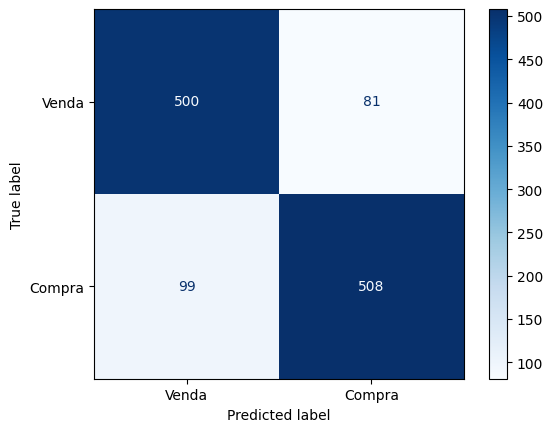

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Avaliação do Modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy: {accuracy*100:.2f}%')

# Predição
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)


# Calcular a matriz de confusão
cm = confusion_matrix(y_test, predicted_labels)

# Exibir a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Venda', 'Compra'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Predições
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

38/38 [==============================] - 0s 10ms/step


In [ ]:
dataframe_teste['Smoothed_Close'] = scaler.inverse_transform(dataframe_teste['Smoothed_Close'].values.reshape(-1, 1))

In [ ]:
colunas_selecionadas = ['Date', 'Label', 'Smoothed_Close']
novo_df = dataframe_teste[colunas_selecionadas]
# Remover as 15 últimas linhas
df_final = novo_df[:-15]
df_final

,Date,Label,Smoothed_Close
0,2019-02-26,1,9.376527
1,2019-02-27,1,9.403478
2,2019-02-28,1,9.427022
3,2019-03-01,1,9.435388
4,2019-03-06,1,9.445054
...,...,...,...
1183,2023-11-30,1,34.907036
1184,2023-12-01,1,34.983332
1185,2023-12-04,0,34.975999
1186,2023-12-05,0,34.953399


In [ ]:
y_test.shape

(1188,)

In [ ]:
df_final.rename(columns={'Label': 'Label_Original'}, inplace = True)

<ipython-input-20-99343f501027>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.rename(columns={'Label': 'Label_Original'}, inplace = True)


In [ ]:
# Converter o numpy.ndarray de volta para um pandas.DataFrame
colunas =['Label']
predicted_dataframe = pd.DataFrame(predicted_labels, columns=colunas)
predicted_dataframe

,Label
0,1
1,1
2,1
3,1
4,1
...,...
1183,0
1184,0
1185,0
1186,0


In [ ]:
# Concatenando os DataFrames
df_concatenado = pd.concat([df_final, predicted_dataframe],axis=1)

In [ ]:
df_concatenado

,Date,Label_Original,Smoothed_Close,Label
0,2019-02-26,1,9.376527,1
1,2019-02-27,1,9.403478,1
2,2019-02-28,1,9.427022,1
3,2019-03-01,1,9.435388,1
4,2019-03-06,1,9.445054,1
...,...,...,...,...
1183,2023-11-30,1,34.907036,0
1184,2023-12-01,1,34.983332,0
1185,2023-12-04,0,34.975999,0
1186,2023-12-05,0,34.953399,0


In [ ]:
# Implementar estratégia de compra e venda
def backtest(data, predictions):
    capital = 1000  # Capital inicial
    acoes = 0  # Quantidade de ações em posse
    capital_hist = [capital]  # Histórico do capital ao longo do tempo
    real_values = []  # Valores reais das ações ao longo do tempo
    predictions_values = []  # Previsões de compra e venda ao longo do tempo

    for index, row in data.iterrows():
        if predictions[index] == 1:
            acoes += capital / row['Smoothed_Close']
            capital = 0
        elif predictions[index] == 0:
            capital += acoes * row['Smoothed_Close']
            acoes = 0

        capital_hist.append(capital + acoes * row['Smoothed_Close'])
        real_values.append(row['Smoothed_Close'])
        predictions_values.append(predictions[index])

    return capital_hist, real_values, predictions_values

historico_capital, real_values, predictions_values = backtest(df_concatenado, predicted_labels)

In [ ]:
historico_capital = np.array(historico_capital)

In [ ]:
Smoothed_Close = df_concatenado.Smoothed_Close.values

In [ ]:
Date = df_concatenado.Date.values

In [ ]:
Label_Original = df_concatenado.Label_Original.values

In [ ]:
#criado um array com os label original
buy_signals_original = np.full(len(Label_Original), np.nan)
sell_signals_original = np.full(len(Label_Original), np.nan)

# Preencher os arrays de compra e venda com base nos sinais
for i in range(len(Label_Original)):
    if Label_Original[i] == 1:
        buy_signals_original[i] = Smoothed_Close[i]
    elif Label_Original[i] == 0:
        sell_signals_original[i] = Smoothed_Close[i]

In [ ]:
#criado um array com os label previstos
buy_signals_previsto = np.full(len(predicted_labels), np.nan)
sell_signals_previsto = np.full(len(predicted_labels), np.nan)

# Preencher os arrays de compra e venda com base nos sinais
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        buy_signals_previsto[i] = Smoothed_Close[i]
    elif predicted_labels[i] == 0:
        sell_signals_previsto[i] = Smoothed_Close[i]

In [ ]:
#CODIgo para o plotly
import plotly.graph_objs as go
fig = go.Figure()

# Criar o gráfico da série temporal
fig = go.Figure()

# Adicionar a linha de valor de fechamento
fig.add_trace(go.Scatter(x=Date, y=Smoothed_Close, mode='lines', name='Closed Value'))

# original
# Adicionar pontos de compra
fig.add_trace(go.Scatter(x=Date, y=buy_signals_original, mode='markers', name='Buy Signal', marker=dict(color='green', size=8, symbol='triangle-up')))
# Adicionar pontos de venda
fig.add_trace(go.Scatter(x=Date, y=sell_signals_original, mode='markers', name='Sell Signal', marker=dict(color='red', size=8, symbol='triangle-down')))


# Previsto
# Adicionar pontos de compra
fig.add_trace(go.Scatter(x=Date, y=buy_signals_previsto, mode='markers', name='Buy Signal previsto', marker=dict(color='yellow', size=8, symbol='triangle-up')))

# Adicionar pontos de venda
fig.add_trace(go.Scatter(x=Date, y=sell_signals_previsto, mode='markers', name='Sell Signal previsto', marker=dict(color='pink', size=8, symbol='triangle-down')))

# valor
fig.add_trace(go.Scatter(x=Date, y=historico_capital, mode='lines', name='Capital ao longo do tempo',yaxis='y2'))


# Configurar layout para usar dois eixos y
fig.update_layout(
    title='Desempenho do modelo via backtest',
    xaxis_title='Período',
    yaxis=dict(
        title='Valor do Ativo',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue')
    ),
    yaxis2=dict(
        title='Capital',
        titlefont=dict(color='orange'),
        tickfont=dict(color='orange'),
        overlaying='y',
        side='right'
    ),
    legend=dict(x=0.1, y=1.0)
)

fig.show()